In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder

train = pd.read_csv('coffee_survey_processed.csv')
train = train[['age',
               'revealed_roast_level', 'cups', 'expertise',
               'brew_High_Skill',
               'brew_Medium_Skill',
               'brew_Low_Skill', 'style',
               'prefer_overall',
               'favorite',
               'know_source',
               'value_cafe',
               'gender', 'stated_roast_level'
               ]]

X = train.drop(columns='stated_roast_level')
y = train['stated_roast_level']

SEED = 42

eval_metrics = {
    'xgboost': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'roc_auc_score': 0},
    'catboost': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'roc_auc_score': 0},
    'random_forest': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'roc_auc_score': 0}
}

train

,age,revealed_roast_level,cups,expertise,brew_High_Skill,brew_Medium_Skill,brew_Low_Skill,style,prefer_overall,favorite,know_source,value_cafe,gender,stated_roast_level
0,<18,No preference,2.0,NaN,1,1,0,Full Bodied,NaN,Other,NaN,NaN,NaN,Light
1,25-34,No preference,1.0,7.0,0,0,0,Fruity,NaN,Pourover,NaN,NaN,NaN,Light
2,<18,Medium,3.0,10.0,1,0,1,Bright,Coffee B,Pourover,NaN,NaN,Other,Light
3,>65,Light,3.0,7.0,0,0,0,Fruity,Coffee D,Cortado,NaN,NaN,NaN,Light
4,25-34,Medium,1.0,6.0,1,1,0,Sweet,Coffee B,Regular drip coffee,NaN,NaN,Female,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,>65,Light,2.0,2.0,0,1,0,Chocolatey,Coffee A,Regular drip coffee,No,No,Female,Medium
3936,>65,Light,2.0,2.0,0,1,0,Nutty,Coffee A,Regular drip coffee,No,No,Male,Light
3937,18-24,Dark,1.0,5.0,1,1,1,Sweet,Coffee C,Latte,Yes,Yes,Male,Light
3938,25-34,Light,2.0,6.0,1,0,0,Nutty,Coffee A,Iced coffee,Yes,Yes,Male,Medium


In [86]:
# let's define an inherent ordering for ordinal columns
orderings = [
    ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '>65'],  # age
    ['No preference', 'Light', 'Medium', 'Dark'],  # revealed_roast_level
]

# Encode features
ordinal_columns = [
    'age',
    'revealed_roast_level',
]

numeric_columns = [
    'cups', 'expertise',
    'brew_High_Skill',
    'brew_Medium_Skill',
    'brew_Low_Skill',
]

nominal_columns = [
    'style',
    'prefer_overall',
    'favorite',
    'know_source',
    'value_cafe',
    'gender',
]

ordinal_imputer = SimpleImputer(strategy='most_frequent')
numeric_imputer = SimpleImputer(strategy='median')
nominal_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer([
    ('ord', Pipeline([('imputer', ordinal_imputer),
                      ('encoder', OrdinalEncoder(categories=orderings))]), ordinal_columns),
    ('nom', Pipeline([('imputer', nominal_imputer),
                      ('encoder', OneHotEncoder(handle_unknown='ignore'))]), nominal_columns),
    ('num', Pipeline([('imputer', numeric_imputer)]), numeric_columns)
])

X_encoded = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
feature_names = [name.replace("ord__", "")
                 .replace("nom__", "")
                 .replace("num__", "")
                 for name in feature_names]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# XGBoost

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.2,  # 80-20 split
    stratify=y_encoded,  # handle class imbalance
    random_state=SEED
)

In [88]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  # number of boosting rounds
    'max_depth': [3, 4, 5, 6],  # depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],  # step size shrinkage
    'subsample': [0.8, 1.0],  # fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # fraction of features used per tree
    'gamma': [0, 0.5, 1],  # minimum loss reduction to make a split
    'reg_lambda': [1, 5, 10],  # L2 regularization strength
    "enable_categorical": [True]
}

num_classes = len(np.unique(y_encoded))

xgb = XGBClassifier(
 objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=SEED
)

grid = GridSearchCV(
    estimator=xgb,
    scoring='accuracy',
    cv=5,
    param_grid=param_grid,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('XGBoost Optimal Hyperparameters:')
print(grid.best_score_)
print(grid.best_params_)

best_model = grid.best_estimator_


XGBoost Optimal Hyperparameters:
0.6966981108344025
{'colsample_bytree': 1.0, 'enable_categorical': True, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 5, 'subsample': 1.0}



 10 fold cross validation results
Accuracy:  0.6919 ± 0.0184
Precision: 0.6888 ± 0.0254
Recall:    0.6919 ± 0.0184
F1 Score:  0.6758 ± 0.0202
ROC AUC:   0.8145 ± 0.0137

 test set results
Accuracy:  0.6904
Precision: 0.6884
Recall:    0.6904
F1 Score:  0.6762
ROC AUC:   0.8071

 classification report
              precision    recall  f1-score   support

           0       0.57      0.19      0.28        91
           1       0.79      0.79      0.79       386
           2       0.60      0.71      0.65       311

    accuracy                           0.69       788
   macro avg       0.65      0.56      0.57       788
weighted avg       0.69      0.69      0.68       788



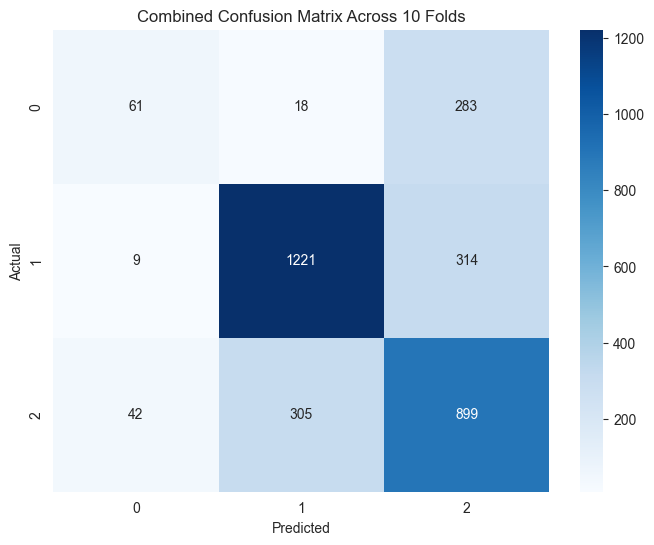

In [89]:
from sklearn.metrics import classification_report

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

accs = []
precs = []
recs = []
f1s = []
rocs = []

cm_total = np.zeros((num_classes, num_classes))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = best_model
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    # Metrics
    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average="weighted"))
    recs.append(recall_score(y_val, y_pred, average="weighted"))
    f1s.append(f1_score(y_val, y_pred, average="weighted"))

    # ROC AUC (needs one-hot)
    y_val_bin = np.eye(num_classes)[y_val]
    rocs.append(roc_auc_score(y_val_bin, y_proba, multi_class="ovr"))

    cm_total += confusion_matrix(y_val, y_pred)


print("\n 10 fold cross validation results")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC:   {np.nanmean(rocs):.4f} ± {np.nanstd(rocs):.4f}")

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)

xgboost_accuracy = accuracy_score(y_test, y_pred_test)
xgboost_precision = precision_score(y_test, y_pred_test, average='weighted')
xgboost_recall = recall_score(y_test, y_pred_test, average='weighted')
xgboost_f1 = f1_score(y_test, y_pred_test, average='weighted')
y_test_bin = np.eye(num_classes)[y_test]
xgboost_roc_auc = roc_auc_score(y_test_bin, y_proba_test, multi_class='ovr')

eval_metrics['xgboost']['accuracy'] = xgboost_accuracy
eval_metrics['xgboost']['precision'] = xgboost_precision
eval_metrics['xgboost']['recall'] = xgboost_recall
eval_metrics['xgboost']['f1_score'] = xgboost_f1
eval_metrics['xgboost']['roc_auc'] = xgboost_roc_auc

print("\n test set results")
print(f"Accuracy:  {xgboost_accuracy:.4f}")
print(f"Precision: {xgboost_precision:.4f}")
print(f"Recall:    {xgboost_recall:.4f}")
print(f"F1 Score:  {xgboost_f1:.4f}")
print(f"ROC AUC:   {xgboost_roc_auc:.4f}")

print("\n classification report")
print(classification_report(y_test, y_pred_test))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_total.astype(int),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Combined Confusion Matrix Across 10 Folds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


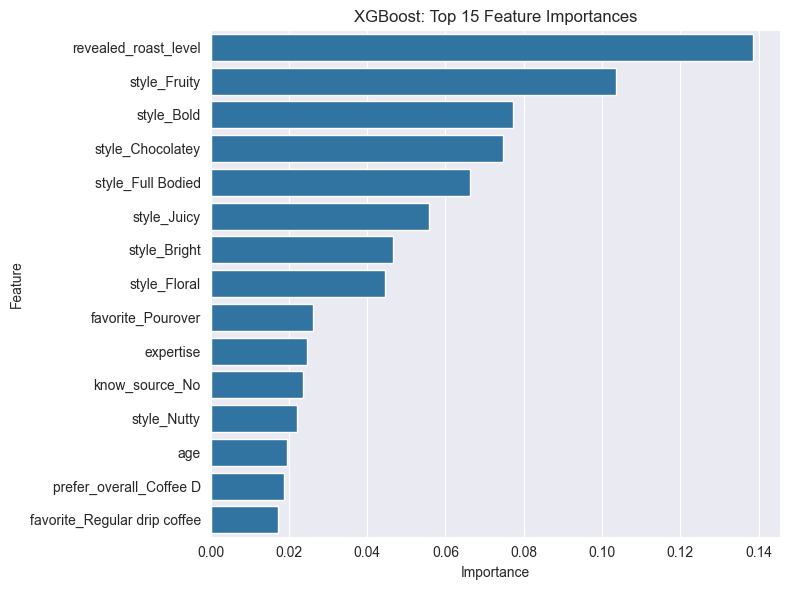

In [90]:
importances = best_model.feature_importances_

# Combine into a dataframe
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature')
plt.title('XGBoost: Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# CatBoost

In [91]:
from catboost import CatBoostClassifier

# param_grid = {
#     "iterations": [300, 500, 800],
#     "learning_rate": [0.03, 0.05, 0.1],
#     "depth": [4, 6, 8],
#     "l2_leaf_reg": [1, 3, 5, 7],
#     "bagging_temperature": [0, 1],
#     "border_count": [32, 64, 128],
# }
param_grid = {
    "iterations": [300, 500],
    "learning_rate": [0.05, 0.1],
    "depth": [4, 6],
    "l2_leaf_reg": [1, 5],
    "bagging_temperature": [0, 1],
}

num_classes = len(np.unique(y_encoded))

cb = CatBoostClassifier(
    loss_function="MultiClass",
    verbose=False,
    random_state=SEED
)

grid = GridSearchCV(
    estimator=cb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('CatBoost Optimal Hyperparameters:')
print(grid.best_score_)
print(grid.best_params_)

best_model = grid.best_estimator_


CatBoost Optimal Hyperparameters:
0.6960648211076376
{'bagging_temperature': 1, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}



 10 fold cross validation results
Accuracy:  0.6894 ± 0.0176
Precision: 0.6799 ± 0.0243
Recall:    0.6894 ± 0.0176
F1 Score:  0.6731 ± 0.0205
ROC AUC:   0.8154 ± 0.0117

 test set results
Accuracy:  0.6865
Precision: 0.6898
Recall:    0.6865
F1 Score:  0.6715
ROC AUC:   0.8090

 classification report
              precision    recall  f1-score   support

           0       0.58      0.16      0.26        91
           1       0.80      0.77      0.79       386
           2       0.58      0.73      0.65       311

    accuracy                           0.69       788
   macro avg       0.65      0.56      0.56       788
weighted avg       0.69      0.69      0.67       788



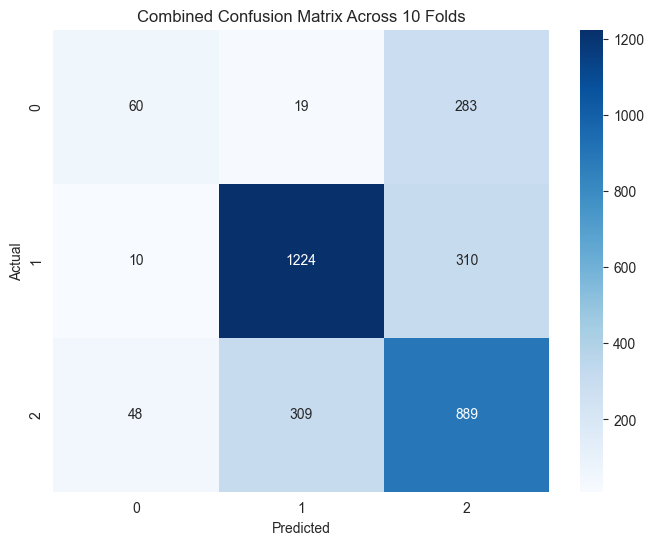

In [92]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

accs = []
precs = []
recs = []
f1s = []
rocs = []

cm_total = np.zeros((num_classes, num_classes))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = best_model
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    # Metrics
    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average="weighted"))
    recs.append(recall_score(y_val, y_pred, average="weighted"))
    f1s.append(f1_score(y_val, y_pred, average="weighted"))

    # ROC AUC (needs one-hot)
    y_val_bin = np.eye(num_classes)[y_val]
    rocs.append(roc_auc_score(y_val_bin, y_proba, multi_class="ovr"))

    cm_total += confusion_matrix(y_val, y_pred)


print("\n 10 fold cross validation results")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC:   {np.nanmean(rocs):.4f} ± {np.nanstd(rocs):.4f}")

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)

catboost_accuracy = accuracy_score(y_test, y_pred_test)
catboost_precision = precision_score(y_test, y_pred_test, average='weighted')
catboost_recall = recall_score(y_test, y_pred_test, average='weighted')
catboost_f1 = f1_score(y_test, y_pred_test, average='weighted')
y_test_bin = np.eye(num_classes)[y_test]
catboost_roc_auc = roc_auc_score(y_test_bin, y_proba_test, multi_class='ovr')

eval_metrics['catboost']['accuracy'] = catboost_accuracy
eval_metrics['catboost']['precision'] = catboost_precision
eval_metrics['catboost']['recall'] = catboost_recall
eval_metrics['catboost']['f1_score'] = catboost_f1
eval_metrics['catboost']['roc_auc'] = catboost_roc_auc

print("\n test set results")
print(f"Accuracy:  {catboost_accuracy:.4f}")
print(f"Precision: {catboost_precision:.4f}")
print(f"Recall:    {catboost_recall:.4f}")
print(f"F1 Score:  {catboost_f1:.4f}")
print(f"ROC AUC:   {catboost_roc_auc:.4f}")

print("\n classification report")
print(classification_report(y_test, y_pred_test))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_total.astype(int),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Combined Confusion Matrix Across 10 Folds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


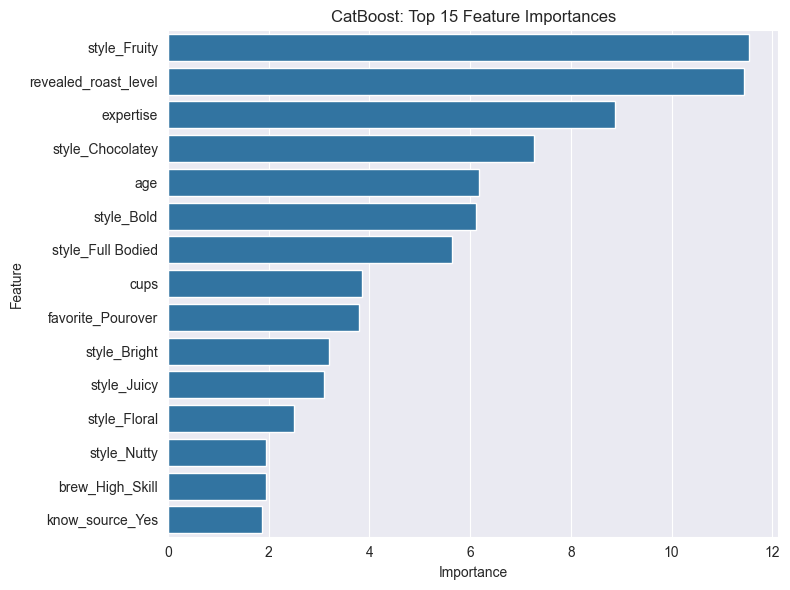

In [93]:
importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature')
plt.title('CatBoost: Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

num_classes = len(np.unique(y_encoded))

cb = RandomForestClassifier(
    verbose=False,
    random_state=SEED,
    n_jobs=-1,
)

grid = GridSearchCV(
    estimator=cb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('Random Forest Optimal Hyperparameters:')
print(grid.best_score_)
print(grid.best_params_)

best_model = grid.best_estimator_


Random Forest Optimal Hyperparameters:
0.6859136423360971
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}



 10 fold cross validation results
Accuracy:  0.6802 ± 0.0233
Precision: 0.6670 ± 0.0322
Recall:    0.6802 ± 0.0233
F1 Score:  0.6595 ± 0.0244
ROC AUC:   0.8035 ± 0.0137

 test set results
Accuracy:  0.6916
Precision: 0.6932
Recall:    0.6916
F1 Score:  0.6747
ROC AUC:   0.7978

 classification report
              precision    recall  f1-score   support

           0       0.58      0.15      0.24        91
           1       0.80      0.78      0.79       386
           2       0.60      0.74      0.66       311

    accuracy                           0.69       788
   macro avg       0.66      0.56      0.56       788
weighted avg       0.69      0.69      0.67       788



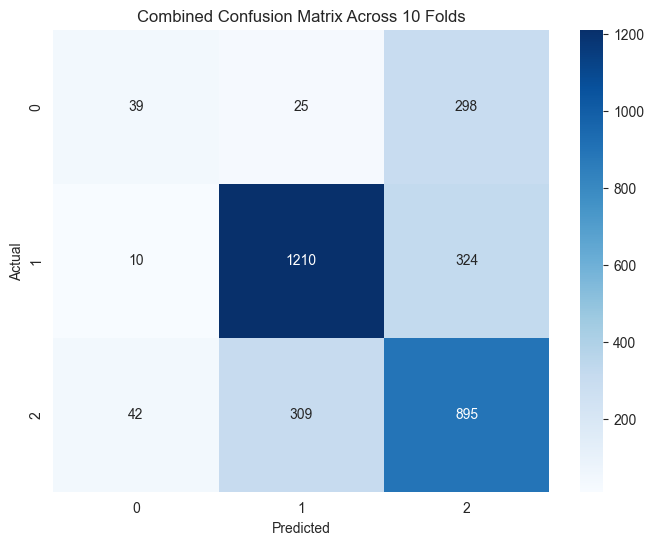

In [95]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

accs = []
precs = []
recs = []
f1s = []
rocs = []

cm_total = np.zeros((num_classes, num_classes))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = best_model
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    # Metrics
    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average="weighted"))
    recs.append(recall_score(y_val, y_pred, average="weighted"))
    f1s.append(f1_score(y_val, y_pred, average="weighted"))

    # ROC AUC (needs one-hot)
    y_val_bin = np.eye(num_classes)[y_val]
    rocs.append(roc_auc_score(y_val_bin, y_proba, multi_class="ovr"))

    cm_total += confusion_matrix(y_val, y_pred)


print("\n 10 fold cross validation results")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC:   {np.nanmean(rocs):.4f} ± {np.nanstd(rocs):.4f}")

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)

random_forest_accuracy = accuracy_score(y_test, y_pred_test)
random_forest_precision = precision_score(y_test, y_pred_test, average='weighted')
random_forest_recall = recall_score(y_test, y_pred_test, average='weighted')
random_forest_f1 = f1_score(y_test, y_pred_test, average='weighted')
y_test_bin = np.eye(num_classes)[y_test]
random_forest_roc_auc = roc_auc_score(y_test_bin, y_proba_test, multi_class='ovr')

eval_metrics['random_forest']['accuracy'] = random_forest_accuracy
eval_metrics['random_forest']['precision'] = random_forest_precision
eval_metrics['random_forest']['recall'] = random_forest_recall
eval_metrics['random_forest']['f1_score'] = random_forest_f1
eval_metrics['random_forest']['roc_auc'] = random_forest_roc_auc

print("\n test set results")
print(f"Accuracy:  {random_forest_accuracy:.4f}")
print(f"Precision: {random_forest_precision:.4f}")
print(f"Recall:    {random_forest_recall:.4f}")
print(f"F1 Score:  {random_forest_f1:.4f}")
print(f"ROC AUC:   {random_forest_roc_auc:.4f}")

print("\n classification report")
print(classification_report(y_test, y_pred_test))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_total.astype(int),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Combined Confusion Matrix Across 10 Folds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


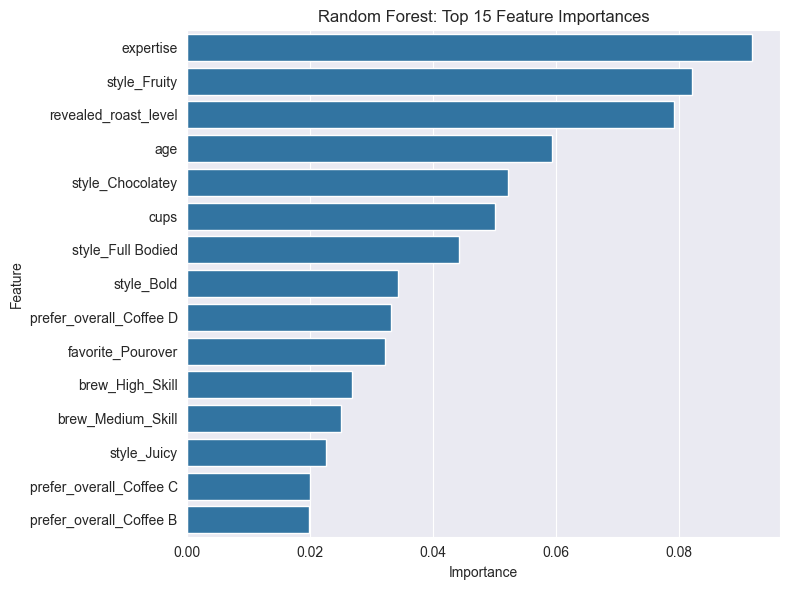

In [96]:
importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature')
plt.title('Random Forest: Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Results

In [97]:
model_comparison = pd.DataFrame({
    'Model': ['XGBoost', 'CatBoost', 'Random Forest'],
    'Accuracy': [eval_metrics['xgboost']['accuracy'], eval_metrics['catboost']['accuracy'],
                 eval_metrics['random_forest']['accuracy']],
    'Precision': [eval_metrics['xgboost']['precision'], eval_metrics['catboost']['precision'],
                  eval_metrics['random_forest']['precision']],
    'Recall': [eval_metrics['xgboost']['recall'], eval_metrics['catboost']['recall'],
               eval_metrics['random_forest']['recall']],
    'F1 Score': [eval_metrics['xgboost']['f1_score'], eval_metrics['catboost']['f1_score'],
                 eval_metrics['random_forest']['f1_score']],
    'ROC AUC': [eval_metrics['xgboost']['roc_auc'], eval_metrics['catboost']['roc_auc'],
                eval_metrics['random_forest']['roc_auc']],
})

display(model_comparison)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.690355,0.688399,0.690355,0.676197,0.807059
1,CatBoost,0.686548,0.689759,0.686548,0.671501,0.808961
2,Random Forest,0.691624,0.693172,0.691624,0.674679,0.797794
